In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/lish-moa/test_features.csv
/kaggle/input/lish-moa/train_features.csv
/kaggle/input/lish-moa/train_targets_scored.csv
/kaggle/input/lish-moa/train_targets_nonscored.csv
/kaggle/input/lish-moa/sample_submission.csv
/kaggle/input/iterative-stratification/iterative-stratification-master/.gitignore
/kaggle/input/iterative-stratification/iterative-stratification-master/LICENSE
/kaggle/input/iterative-stratification/iterative-stratification-master/README.md
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.cfg
/kaggle/input/iterative-stratification/iterative-stratification-master/setup.py
/kaggle/input/iterative-stratification/iterative-stratification-master/.travis.yml
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/__init__.py
/kaggle/input/iterative-stratification/iterative-stratification-master/tests/test_ml_stratifiers.py
/kaggle/input/iterative-stratification/iterative-stratification-master/iterstrat/__init__.py
/kagg

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/permutation-importance')
sys.path.insert(2, '/kaggle/input/iterative-stratification/iterative-stratification-master')

## Import Packages

In [3]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import tensorflow as tf
from tensorflow.keras import layers, Sequential, Model, backend
from tensorflow.keras.layers import Input, Dense, Flatten, LeakyReLU
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import Add, Concatenate, Average
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow_addons.optimizers import AdamW, Lookahead
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils  import plot_model

/opt/conda/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.2.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Helper Functions

In [4]:
def logloss_metric(df, y_true, y_pred):
    
    metrics = []
    
    # Calculate log_loss individually for every field
    for _target in df.columns:
        metrics.append(log_loss(y_true.loc[:, _target], 
                                y_pred.loc[:, _target].astype(float), 
                                labels=[0,1]))
    
    # Return mean of individual log_loss values
    return np.mean(metrics)

In [5]:
def logloss(y_true, y_pred):
    p_min = 0.0005
    p_max = 1 - p_min
    y_pred = tf.clip_by_value(y_pred, p_min, p_max)
    return -backend.mean(y_true * backend.log(y_pred) + (1 - y_true) * backend.log(1 - y_pred))

In [6]:
class Autoencoder(Model):
    def __init__(self, n_features, encoding_dim):
        super(Autoencoder, self).__init__()        
        self.encoder = Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(encoding_dim,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(encoding_dim,activation='relu'),
        ])
        
        self.decoder = Sequential([
        layers.Dense(encoding_dim,activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.25),
        layers.Dense(n_features)
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
def pca_fet(train, test, features, kind, n_components, SEED=10):
    
    # Combine train and test datasets
    train_ = train[features].copy()
    test_ = test[features].copy()
    data = pd.concat([train_, test_], axis=0)
    
    # Perform PCA to create new features
    pca = PCA(n_components=n_components, random_state=SEED)
    data = pca.fit_transform(data)
    columns = [f'pca_{kind}{i + 1}' for i in range(n_components)]
    data = pd.DataFrame(data, columns = columns)
    
    # Append new features to train and test datasets
    train_ = data.iloc[:train.shape[0]]
    test_ = data.iloc[train.shape[0]:].reset_index(drop=True)
    train = pd.concat([train, train_], axis=1)
    test = pd.concat([test, test_], axis=1)
    return train, test

In [8]:
def data_preprocess(dataset_dict, SEED=10):
    
    # Extract datasets path from input dict
    train_ds = dataset_dict['train_dataset']
    train_labels_ds = dataset_dict['train_labels_scored']
    predict_ds = dataset_dict['predict_dataset']
    
    # Read and display individual dataframe shapes
    train_df = pd.read_csv(train_ds)
    train_label_df = pd.read_csv(train_labels_ds)
    predict_df = pd.read_csv(predict_ds)
    '''
    print("\n------------- Input Dataset Shapes -------------")
    print("train_df: {}".format(train_df.shape))
    print("train_label_df: {}".format(train_label_df.shape))
    print("predict_df: {}".format(predict_df.shape))
    '''
    
    # Drop training rows with cp_type = ctl_vehicle
    train_label_df = train_label_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
    train_df = train_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
    train_samples = train_df.shape[0]
    '''
    print("\n------------- Dataset Shapes after removing ctl_vehicle rows -------------")
    print("train_df: {}".format(train_df.shape))
    print("train_label_df: {}".format(train_label_df.shape))
    '''
    
    # Separate the columns for gene expression and cell viability
    features_g = [col for col in train_df.columns if col.startswith('g-')]
    features_c = [col for col in train_df.columns if col.startswith('c-')]
    
    # Generate PCA features
    #print("\n------------- Performing PCA -------------")
    train, test = pca_fet(train_df, predict_df, features_g, kind='g', n_components=250, SEED=SEED)
    train, test = pca_fet(train, test, features_c, kind='c', n_components=40, SEED=SEED)
    #print("Dataset size after PCA: \ntrain: {} \npredict: {}".format(train.shape, test.shape))
    
    # Combined both input dataframes
    combined_df = train.append(test, sort=False, ignore_index=True)
    
    # Feature Engineering
    combined_df['cp_type_enc'] = combined_df['cp_type'].map({'trt_cp': 0, 'ctl_vehicle': 1})
    combined_df['cp_dose_enc'] = combined_df['cp_dose'].map({'D1': 0, 'D2': 1})
    combined_df['cp_time_days'] = combined_df['cp_time'].apply(lambda x: x//24)
    combined_df.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
    
    combined_df['g_sum'] = combined_df[features_g].sum(axis=1)
    combined_df['g_mean'] = combined_df[features_g].mean(axis=1)
    combined_df['g_std'] = combined_df[features_g].std(axis=1)
    combined_df['g_kurt'] = combined_df[features_g].kurtosis(axis=1)
    combined_df['g_skew'] = combined_df[features_g].skew(axis=1)
    combined_df['c_sum'] = combined_df[features_c].sum(axis=1)
    combined_df['c_mean'] = combined_df[features_c].mean(axis=1)
    combined_df['c_std'] = combined_df[features_c].std(axis=1)
    combined_df['c_kurt'] = combined_df[features_c].kurtosis(axis=1)
    combined_df['c_skew'] = combined_df[features_c].skew(axis=1)
    combined_df['gc_sum'] = combined_df[features_g + features_c].sum(axis=1)
    combined_df['gc_mean'] = combined_df[features_g + features_c].mean(axis=1)
    combined_df['gc_std'] = combined_df[features_g + features_c].std(axis=1)
    combined_df['gc_kurt'] = combined_df[features_g + features_c].kurtosis(axis=1)
    combined_df['gc_skew'] = combined_df[features_g + features_c].skew(axis=1)
    
    # Segregate train and predict datasets
    train_label_df.drop(['sig_id'], axis=1, inplace=True)
    train_y = train_label_df.values
    train_x = combined_df[:train_samples].values
    predict_x = combined_df[train_samples:].values
    
    # Scaler for numerical values
    scaler = MinMaxScaler()
    train_x = scaler.fit_transform(train_x)
    predict_x = scaler.transform(predict_x)

    '''
    print("\n------------- Final Dataset Shapes -------------")
    print("\ntrain_x: {}".format(train_x.shape))
    print("train_y: {}".format(train_y.shape))
    print("predict_x: {}".format(predict_x.shape))
    '''
    
    return train_x, train_y, predict_x

In [9]:
def moa_prediction_model(input_shape_1, input_shape_2, output_shape):
    
    # Input Layers
    x_input_1 = Input(shape=(input_shape_1, ))
    x1 = BatchNormalization()(x_input_1)
    
    x_input_2 = Input(shape=(input_shape_2, ))
    x2 = BatchNormalization()(x_input_2)
    
    # Fully-connected Layers
    x1 = Dense(units=2048, kernel_regularizer=l2(0.0005))(x1)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.4)(x1)
    
    x1 = Dense(units=512, kernel_regularizer=l2(0.0001))(x1)
    x1 = LeakyReLU()(x1)
    x1 = BatchNormalization()(x1)
    x1 = Dropout(rate=0.25)(x1)
    
    x2 = Dense(units=512, kernel_regularizer=l2(0.0001))(x2)
    x2 = LeakyReLU()(x2)
    x2 = BatchNormalization()(x2)
    x2 = Dropout(rate=0.25)(x2)
    
    x3 = Concatenate()([x1, x2])
    x3 = BatchNormalization()(x3)
    
    x3 = Dense(units=2048, kernel_regularizer=l2(0.0005))(x3)
    x3 = LeakyReLU()(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(rate=0.4)(x3)
    
    x3 = Dense(units=512, kernel_regularizer=l2(0.0001))(x3)
    x3 = LeakyReLU()(x3)
    x3 = BatchNormalization()(x3)
    x3 = Dropout(rate=0.25)(x3)
    
    x4 = Add()([x2, x3])
    x4 = BatchNormalization()(x4)
    
    x4 = Dense(units=2048, kernel_regularizer=l2(0.0005))(x4)
    x4 = LeakyReLU()(x4)
    x4 = BatchNormalization()(x4)
    x4 = Dropout(rate=0.4)(x4)
    
    x4 = Dense(units=512, kernel_regularizer=l2(0.0001))(x4)
    x4 = LeakyReLU()(x4)
    x4 = BatchNormalization()(x4)
    x4 = Dropout(rate=0.25)(x4)
    
    x5 = Average()([x4, x1])
    x5 = BatchNormalization()(x5)
    
    x5 = Dense(units=512, kernel_regularizer=l2(0.0001))(x5)
    x5 = LeakyReLU()(x5)
    x5 = BatchNormalization()(x5)
    x5 = Dropout(rate=0.25)(x5)
    
    # Output Layer
    x = Dense(units=output_shape, activation='sigmoid')(x5)

    # Create Keras Model instance
    model = Model(inputs=[x_input_1, x_input_2], outputs=x, name='MOA_Prediction_Model')

    return model

## Data Preprocessing

### Set file paths for train and predict datasets

In [10]:
train_dataset = "/kaggle/input/lish-moa/train_features.csv"
train_labels_scored = "/kaggle/input/lish-moa/train_targets_scored.csv"
predict_dataset = "/kaggle/input/lish-moa/test_features.csv"

### Preparing the Auto-encoder

In [11]:
# Read and display individual dataframe shapes
train_df = pd.read_csv(train_dataset)
train_label_df = pd.read_csv(train_labels_scored)
train_label_df.drop(['sig_id'], axis=1, inplace=True)
predict_df = pd.read_csv(predict_dataset)

# Data that has no MoAs
non_moa = train_df.loc[train_label_df.sum(axis=1)==0]
non_moa = non_moa.append(predict_df.loc[predict_df['cp_type']=='ctl_vehicle'].drop('cp_type',axis=1))
non_moa.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)

# Non MoA Stratifier
cp_type_train = train_df['cp_type']
non_moa_stratifier = cp_type_train[train_label_df.sum(axis=1)==0].append(predict_df.loc[predict_df['cp_type']=='ctl_vehicle','cp_type'])

# Drop training rows with cp_type = ctl_vehicle
train_label_df = train_label_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
train_df = train_df.loc[train_df['cp_type']=='trt_cp'].reset_index(drop=True)
train_df.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
predict_df.drop(['sig_id', 'cp_type', 'cp_dose', 'cp_time'], axis=1, inplace=True)
print("train_df: {}".format(train_df.shape))
print("train_label_df: {}".format(train_label_df.shape))
print("predict_df: {}".format(train_label_df.shape))
print("non_moa: {}".format(non_moa.shape))

# Scaler for numerical values
scaler = StandardScaler()
data_train = scaler.fit_transform(train_df)
data_test = scaler.transform(predict_df)
non_moa = scaler.transform(non_moa)

# Split into train/test datasets
non_moa_train, non_moa_test = train_test_split(non_moa, test_size=0.1, stratify=non_moa_stratifier.values)
print("non_moa_train: {}".format(non_moa_train.shape))
print("non_moa_test: {}".format(non_moa_test.shape))

train_df: (21948, 872)
train_label_df: (21948, 206)
predict_df: (21948, 206)
non_moa: (9725, 872)
non_moa_train: (8752, 872)
non_moa_test: (973, 872)


In [12]:
# Build and train auto-encoder
autoencoder = Autoencoder(non_moa_train.shape[1], 1024)
autoencoder.compile(optimizer=Lookahead(AdamW(lr=1e-2, 
                                              weight_decay=1e-5, 
                                              clipvalue=700), 
                                        sync_period=10), 
                    loss='mse')

ae_reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, 
                                 min_lr=1e-5, patience=5, 
                                 verbose=1, mode='min')

ae_early_stopping = EarlyStopping(monitor="val_loss", mode="min", 
                                  restore_best_weights=True, 
                                  patience=10, verbose=1)

hist = autoencoder.fit(non_moa_train, non_moa_train, batch_size=128, 
                       verbose=1, epochs=512, shuffle=True, 
                       validation_data=(non_moa_test, non_moa_test), 
                       callbacks=[ae_reduce_lr, ae_early_stopping])

Epoch 1/512
69/69 [==============================] - 1s 10ms/step - loss: 0.9941 - val_loss: 0.9131
Epoch 2/512
69/69 [==============================] - 1s 9ms/step - loss: 0.6054 - val_loss: 0.5468
Epoch 3/512
69/69 [==============================] - 1s 9ms/step - loss: 0.5097 - val_loss: 0.4677
Epoch 4/512
69/69 [==============================] - 1s 7ms/step - loss: 0.4599 - val_loss: 0.4522
Epoch 5/512
69/69 [==============================] - 0s 7ms/step - loss: 0.4305 - val_loss: 0.4233
Epoch 6/512
69/69 [==============================] - 0s 7ms/step - loss: 0.4099 - val_loss: 0.4039
Epoch 7/512
69/69 [==============================] - 0s 7ms/step - loss: 0.3948 - val_loss: 0.3892
Epoch 8/512
69/69 [==============================] - 0s 7ms/step - loss: 0.3815 - val_loss: 0.3793
Epoch 9/512
69/69 [==============================] - 0s 7ms/step - loss: 0.3741 - val_loss: 0.3728
Epoch 10/512
69/69 [==============================] - 0s 7ms/step - loss: 0.3645 - val_loss: 0.3591
Epoch 11

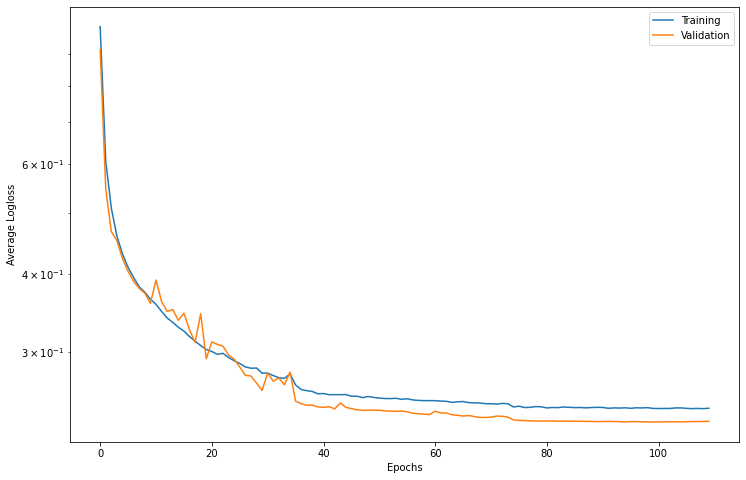

In [13]:
plt.figure(figsize=(12,8))
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.yscale('log')
plt.yticks(ticks=[1E-1])
plt.xlabel('Epochs')
plt.ylabel('Average Logloss')
plt.legend(['Training','Validation'])

In [14]:
# Test difference in reconstruction errors for data with/without any MoAs. 
# Note: A bigger difference is a good sign
autoencoded_train = autoencoder.encoder(data_train).numpy()
autoencoded_test = autoencoder.encoder(data_test).numpy()
autoencoded_non_moa_test = autoencoder.encoder(non_moa_test).numpy()
print("autoencoded_train: {}".format(autoencoded_train.shape))
print("autoencoded_test: {}".format(autoencoded_test.shape))
print("autoencoded_non_moa_test: {}".format(autoencoded_non_moa_test.shape))

autoencoder_error = mean_squared_error(non_moa_test, 
                                       autoencoder.decoder(autoencoded_non_moa_test).numpy())
print("Autoencoder reconstruction error for Non MoA is " + str(autoencoder_error))

moa_train = data_train[train_label_df.sum(axis=1)!=0]
autoencoder_error = mean_squared_error(moa_train, 
                                       autoencoder.decoder(autoencoder.encoder(moa_train).numpy()).numpy())
print("Autoencoder reconstruction error for train data with MoA is " + str(autoencoder_error))

autoencoded_train: (21948, 1024)
autoencoded_test: (3982, 1024)
autoencoded_non_moa_test: (973, 1024)
Autoencoder reconstruction error for Non MoA is 0.23198070133060644
Autoencoder reconstruction error for train data with MoA is 0.33648962195835413


### Process train and predict features datasets

In [15]:
# Read and display individual dataframe shapes
train_df = pd.read_csv(train_dataset)
train_label_df = pd.read_csv(train_labels_scored)
train_label_df.drop(['sig_id'], axis=1, inplace=True)
predict_df = pd.read_csv(predict_dataset)

print("train_df: {}".format(train_df.shape))
print("train_label_df: {}".format(train_label_df.shape))
print("predict_df: {}".format(predict_df.shape))

train_df: (23814, 876)
train_label_df: (23814, 206)
predict_df: (3982, 876)


In [16]:
datasets = {}
datasets['train_dataset'] = train_dataset
datasets['train_labels_scored'] = train_labels_scored
datasets['predict_dataset'] = predict_dataset

In [17]:
top_feats = [  0,   2,   3,   4,   5,   6,   7,   8,  10,  11,  12,  13,  14,
        15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
        28,  29,  30,  32,  33,  34,  35,  36,  38,  39,  40,  41,  42,
        43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
        56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,
        69,  71,  72,  73,  75,  76,  77,  78,  79,  80,  81,  82,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136,
       137, 138, 139, 140, 141, 142, 143, 145, 146, 148, 149, 151, 152,
       154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166,
       167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 180,
       181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
       207, 208, 209, 210, 211, 212, 213, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 237, 239, 240, 241, 242, 244, 245, 246, 247, 248, 249,
       250, 251, 252, 253, 254, 256, 257, 258, 259, 260, 261, 262, 263,
       264, 265, 266, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 291,
       292, 293, 294, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306,
       308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 320, 321,
       322, 323, 324, 325, 327, 328, 329, 330, 332, 333, 334, 335, 337,
       338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350,
       352, 353, 354, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365,
       367, 368, 369, 370, 371, 372, 373, 374, 376, 377, 378, 379, 382,
       383, 384, 385, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396,
       397, 398, 399, 401, 402, 403, 404, 405, 407, 408, 409, 410, 411,
       412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424,
       425, 426, 427, 428, 429, 430, 431, 432, 434, 435, 436, 437, 438,
       439, 440, 441, 442, 443, 444, 445, 446, 447, 448, 450, 451, 452,
       453, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465, 466,
       467, 469, 470, 471, 472, 473, 474, 475, 476, 478, 480, 481, 482,
       484, 485, 486, 487, 488, 489, 490, 491, 492, 493, 494, 495, 496,
       497, 499, 500, 501, 502, 503, 505, 506, 508, 509, 510, 511, 512,
       514, 515, 516, 517, 518, 520, 521, 522, 523, 524, 525, 526, 527,
       528, 530, 531, 532, 533, 534, 535, 536, 537, 538, 539, 540, 541,
       542, 543, 544, 545, 546, 547, 548, 552, 553, 554, 556, 557, 558,
       559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571,
       572, 575, 576, 577, 578, 581, 582, 583, 584, 585, 586, 587, 588,
       589, 590, 591, 592, 593, 594, 596, 597, 598, 599, 600, 601, 602,
       603, 604, 605, 607, 608, 609, 610, 611, 613, 614, 615, 616, 618,
       619, 620, 621, 623, 624, 627, 628, 629, 631, 632, 633, 634, 635,
       636, 637, 638, 639, 640, 642, 644, 645, 646, 647, 648, 649, 651,
       653, 654, 655, 656, 657, 658, 659, 661, 662, 663, 664, 665, 666,
       667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679,
       680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692,
       694, 695, 696, 697, 698, 699, 700, 701, 705, 706, 707, 708, 709,
       710, 711, 712, 713, 714, 715, 717, 718, 719, 720, 721, 722, 723,
       724, 725, 726, 727, 729, 730, 731, 732, 734, 735, 736, 737, 738,
       739, 740, 741, 742, 743, 745, 746, 747, 748, 749, 750, 751, 752,
       753, 754, 756, 757, 758, 759, 760, 761, 762, 763, 764, 766, 767,
       768, 769, 770, 771, 772, 773, 774, 775, 776, 778, 779, 780, 781,
       782, 783, 784, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795,
       797, 798, 799, 800, 801, 802, 803, 804, 806, 807, 808, 809, 810,
       811, 812, 813, 815, 816, 818, 819, 820, 821, 822, 823, 824, 825,
       827, 828, 829, 830, 831, 832, 834, 835, 836, 837, 838, 839, 840,
       842, 843, 844, 845, 846, 847, 848, 849, 850, 851, 852, 853, 854,
       855, 856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867,
       868, 869, 870, 871, 873, 874]


print(len(top_feats))

786


In [18]:
Xtrain, Ytrain, Xpredict = data_preprocess(datasets)

In [19]:
Xtrain2 = Xtrain[:, top_feats]
Xpredict2 = Xpredict[:, top_feats]
Xtrain = np.concatenate((Xtrain, autoencoded_train),axis=1)
Xpredict = np.concatenate((Xpredict, autoencoded_test),axis=1)

print("Xtrain: {}".format(Xtrain.shape))
print("Xtrain2: {}".format(Xtrain2.shape))
print("Ytrain: {}".format(Ytrain.shape))
print("Xpredict: {}".format(Xpredict.shape))
print("Xpredict2: {}".format(Xpredict2.shape))

Xtrain: (21948, 2204)
Xtrain2: (21948, 786)
Ytrain: (21948, 206)
Xpredict: (3982, 2204)
Xpredict2: (3982, 786)


## Build and validate the model

In [20]:
# Define the model hyperparameters
mini_batch_size = 128

# Prediction Clipping Thresholds
p_min = 0.0005
p_max = 1 - p_min

# Set number of K-Folds
FOLD = 10

# Set seeds for model training
np.random.seed(1)
seeds = np.random.randint(0, 100, size=3)

# Create the model
model = moa_prediction_model(Xtrain.shape[1], Xtrain2.shape[1], Ytrain.shape[1])
model.summary()

Model: "MOA_Prediction_Model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2204)]       0                                            
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 2204)         8816        input_1[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2048)         4515840     batch_normalization_3[0][0]      
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 2048)         0           dense_4[0][0]                    
_______________________________________________________________________________

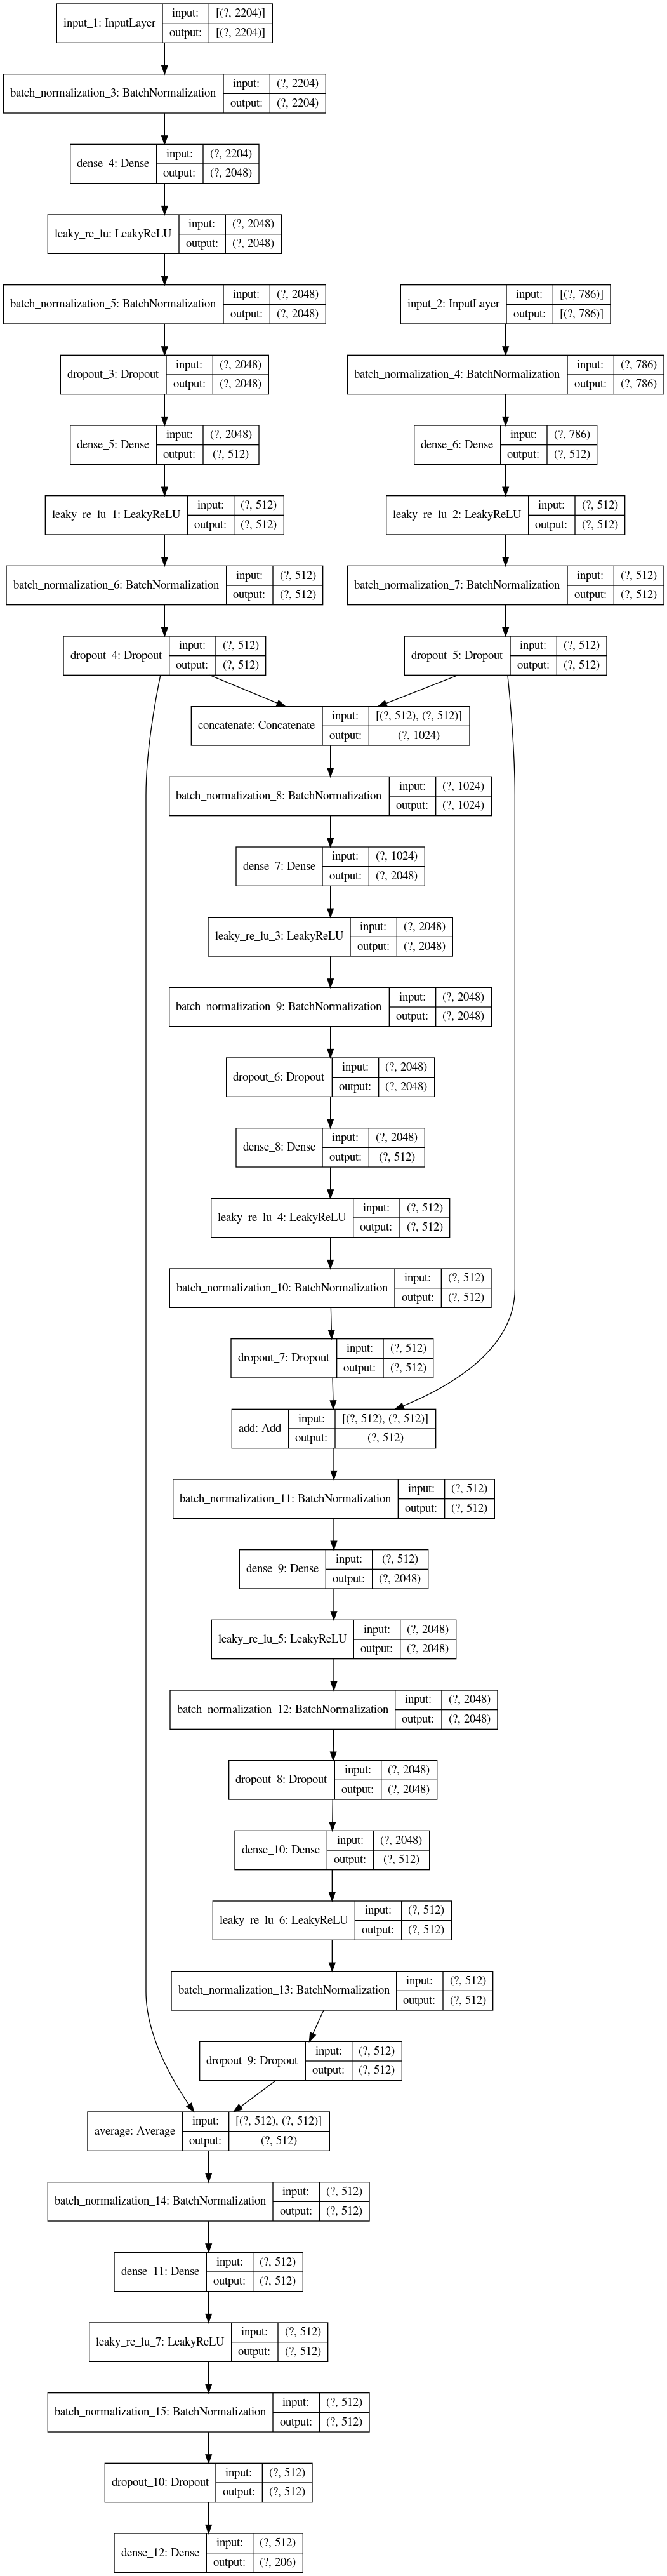

In [21]:
plot_model(model, to_file='/kaggle/working/moa_prediction_model.png', show_shapes=True, show_layer_names=True)

In [22]:
val_metric = 0
y_pred_final = 0
idx = 0

for seed in seeds:
    seed_metric = 0
    
    # Data Preprocessing
    Xtrain, Ytrain, Xpredict = data_preprocess(datasets, seed)
    Xtrain2 = Xtrain[:, top_feats]
    Xpredict2 = Xpredict[:, top_feats]
    Xtrain = np.concatenate((Xtrain, autoencoded_train),axis=1)
    Xpredict = np.concatenate((Xpredict, autoencoded_test),axis=1)
    
    # Define K-fold cross validation test harness
    kfold = MultilabelStratifiedKFold(n_splits=FOLD, shuffle=True, random_state=seed)
    
    for i, (train, val) in enumerate(kfold.split(Xtrain, Ytrain)):

        idx += 1
        print("\n---------------- Fold {} ----------------".format(idx))

        train_x_tmp, val_x_tmp = Xtrain[train], Xtrain[val]
        train_x_tmp2, val_x_tmp2 = Xtrain2[train], Xtrain2[val]
        train_y_tmp, val_y_tmp = Ytrain[train], Ytrain[val]

        # Create the model
        model = moa_prediction_model(Xtrain.shape[1], Xtrain2.shape[1], Ytrain.shape[1])

        # Compile model to configure the learning process
        model.compile(loss=BinaryCrossentropy(label_smoothing=p_min), 
                      metrics=logloss,
                      optimizer=Lookahead(AdamW(lr=1e-2, 
                                                weight_decay=1e-5, 
                                                clipvalue=700), 
                                          sync_period=10))

        # Early stopping policy
        early = EarlyStopping(monitor="val_logloss", mode="min", 
                              restore_best_weights=True, 
                              patience=10, verbose=0)

        # Reduce LR on plateau policy
        reduce_lr = ReduceLROnPlateau(monitor="val_logloss", factor=0.1, 
                                      min_lr=1e-5, patience=5, 
                                      verbose=0, mode='min')

        # Fit the model
        history = model.fit(x=[train_x_tmp, train_x_tmp2], y=train_y_tmp, 
                            batch_size=mini_batch_size, epochs=85, verbose=0,
                            callbacks=[reduce_lr, early], workers=5,
                            validation_data=([val_x_tmp, val_x_tmp2], val_y_tmp))

        # Get logloss metric on validation dataset
        y_pred = model.predict([val_x_tmp, val_x_tmp2])
        y_pred = np.clip(y_pred, p_min, p_max)
        true_labels = pd.DataFrame(val_y_tmp, columns=train_label_df.columns)
        pred_labels = pd.DataFrame(y_pred, columns=train_label_df.columns)
        metric = logloss_metric(train_label_df, true_labels, pred_labels)
        val_metric += metric
        seed_metric += metric
        
        # Make predictions
        pred_final = model.predict([Xpredict, Xpredict2])
        y_pred_final += pred_final
        print("Seed: {} | Fold: {} | Log Loss: {}".format(seed, (i+1), metric))
    
    print("\nSeed: {} | Aggregate Log Loss: {}".format(seed, (seed_metric / FOLD)))
    print("--------------------------------------------------------------------\n")

print("Total #iterations: {}".format(idx))
val_metric /= float(idx)
y_pred_final /= float(idx)
print("Validation Logloss Metric: {}".format(val_metric))


---------------- Fold 1 ----------------
Seed: 37 | Fold: 1 | Log Loss: 0.016143276402026962

---------------- Fold 2 ----------------
Seed: 37 | Fold: 2 | Log Loss: 0.016348736755993704

---------------- Fold 3 ----------------
Seed: 37 | Fold: 3 | Log Loss: 0.015912888977591747

---------------- Fold 4 ----------------
Seed: 37 | Fold: 4 | Log Loss: 0.01632061362437996

---------------- Fold 5 ----------------
Seed: 37 | Fold: 5 | Log Loss: 0.0162805895760685

---------------- Fold 6 ----------------
Seed: 37 | Fold: 6 | Log Loss: 0.01645887940398082

---------------- Fold 7 ----------------
Seed: 37 | Fold: 7 | Log Loss: 0.016479268792288664

---------------- Fold 8 ----------------
Seed: 37 | Fold: 8 | Log Loss: 0.01619291666928454

---------------- Fold 9 ----------------
Seed: 37 | Fold: 9 | Log Loss: 0.016151545434188723

---------------- Fold 10 ----------------
Seed: 37 | Fold: 10 | Log Loss: 0.016245072612580784

Seed: 37 | Aggregate Log Loss: 0.01625337882483844
-----------

## Create submission file

In [23]:
y_pred_final = np.clip(y_pred_final, p_min, p_max)
pred_labels = pd.DataFrame(y_pred_final, columns=train_label_df.columns)
pred_labels.loc[predict_df['cp_type']=='ctl_vehicle', train_label_df.columns] = 0
print(pred_labels.shape)
pred_labels.head()

(3982, 206)


,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,0.001305,0.001967,0.001612,0.015903,0.030163,0.006962,0.002271,0.006782,0.000500,0.009897,...,0.000629,0.001196,0.003335,0.001704,0.000702,0.000722,0.000992,0.001931,0.002077,0.001392
1,0.000500,0.000904,0.003227,0.001831,0.000716,0.001342,0.003728,0.010765,0.012933,0.008341,...,0.001409,0.002266,0.003317,0.000500,0.012106,0.000941,0.002763,0.001265,0.011060,0.003716
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000820,0.001044,0.002201,0.012228,0.014583,0.004581,0.003099,0.007255,0.000596,0.016633,...,0.000749,0.001004,0.003054,0.002699,0.008307,0.000653,0.003440,0.002907,0.001032,0.002972
4,0.002269,0.001750,0.002342,0.014880,0.014408,0.003795,0.006728,0.002457,0.000714,0.009742,...,0.001131,0.000668,0.004599,0.001588,0.001485,0.000914,0.001217,0.002578,0.001370,0.002427


In [24]:
submit_df = pd.read_csv("/kaggle/input/lish-moa/sample_submission.csv")
submit_df.loc[:, submit_df.columns != 'sig_id'] = pred_labels
submit_df.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.001305,0.001967,0.001612,0.015903,0.030163,0.006962,0.002271,0.006782,0.000500,...,0.000629,0.001196,0.003335,0.001704,0.000702,0.000722,0.000992,0.001931,0.002077,0.001392
1,id_001897cda,0.000500,0.000904,0.003227,0.001831,0.000716,0.001342,0.003728,0.010765,0.012933,...,0.001409,0.002266,0.003317,0.000500,0.012106,0.000941,0.002763,0.001265,0.011060,0.003716
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.000820,0.001044,0.002201,0.012228,0.014583,0.004581,0.003099,0.007255,0.000596,...,0.000749,0.001004,0.003054,0.002699,0.008307,0.000653,0.003440,0.002907,0.001032,0.002972
4,id_0027f1083,0.002269,0.001750,0.002342,0.014880,0.014408,0.003795,0.006728,0.002457,0.000714,...,0.001131,0.000668,0.004599,0.001588,0.001485,0.000914,0.001217,0.002578,0.001370,0.002427


In [25]:
submit_df.to_csv("/kaggle/working/submission.csv", index=False)